# Introduction: sandbox for developing digital water systems

## Objective

The goal of this notebook is to familiarize one self with the simulation environment and tools used in the workshop for building digital twins.

### Tools of the trade
**Explain what each tool does**
1. pyswmm
2. swmmio
3. pystroms
4. matplotlib
5. numpy
6. pandas
7. scikit-learn
8. pytorch

In [1]:
import pyswmm
import swmmio
import pystorms
import matplotlib.pyplot as plt


TODO: Add a image of the network or networks we will be using in this example.


Link to the where they can find more information about the networks.


Reach out to the ASCE to get a list of the names of the people so we can communicate information with them. 

### Simulating a stormwater network in EPA-SWMM via python

In [2]:
# Load a input file
input_file = pystorms.load_network("theta")

In [3]:
# pystorms provides a collection of real-life inspired stormwater networks.
# In this example, we are just loading a network.
print(f"SWMM input file path: {input_file}")

SWMM input file path: /Users/aerispa/projectcode/ewri2023_DigitalWater101/venv/lib/python3.9/site-packages/pystorms/networks/theta.inp


👨🏼‍🎓 Bonus Question: Try running a simulation with an other stormwater network from pystorms or may be one of your own stormwater networks.

In [4]:
# Once we have the stormwater network, we hand over the input file to the awesome pyswmm
# pyswmm helps us control EPA-SWMM from python, so that we don't have to press buttons anymore 😆
simulation = pyswmm.Simulation(inputfile=input_file)

# run the simulation
simulation.execute()


... SWMM Version 5.1.14
 o  Retrieving project data
 o  Retrieving project data
... Run Complete

Okay, this is cool, but why do we need python to do this? I can run this by using good old EPA-SWMM GUI

In [5]:
# pyswmm gives us the power to intervean during the simulation and make changes
simulation = pyswmm.Simulation(inputfile=input_file)

for step in simulation:
    # pyswmm returns current step as python's datetime object
    if simulation.current_time.minute % 30.0 == 0:
        print(f"Simulation Time: {simulation.current_time}")

simulation.close()

Simulation Time: 2018-02-25 00:00:01
 o  Retrieving project data
Simulation Time: 2018-02-25 00:00:31
Simulation Time: 2018-02-25 00:30:01
Simulation Time: 2018-02-25 00:30:31
Simulation Time: 2018-02-25 01:00:01
Simulation Time: 2018-02-25 01:00:31
Simulation Time: 2018-02-25 01:30:01
Simulation Time: 2018-02-25 01:30:31
Simulation Time: 2018-02-25 02:00:08
Simulation Time: 2018-02-25 02:00:27
Simulation Time: 2018-02-25 02:00:47
Simulation Time: 2018-02-25 02:30:09
Simulation Time: 2018-02-25 02:30:23
Simulation Time: 2018-02-25 02:30:37
Simulation Time: 2018-02-25 02:30:51
Simulation Time: 2018-02-25 03:00:08
Simulation Time: 2018-02-25 03:00:20
Simulation Time: 2018-02-25 03:00:31
Simulation Time: 2018-02-25 03:00:43
Simulation Time: 2018-02-25 03:00:54
Simulation Time: 2018-02-25 03:30:07
Simulation Time: 2018-02-25 03:30:17
Simulation Time: 2018-02-25 03:30:27
Simulation Time: 2018-02-25 03:30:37
Simulation Time: 2018-02-25 03:30:47
Simulation Time: 2018-02-25 03:30:57
Simulation

### Displaying results from simulations

There are two ways we can do this:
1. We can log the values during simulation
2. We can process output files

Both examples are displayed below:

In [9]:
# How do I know which nodes are in the network?
# You can always open the input file in SWMM GUI :D 
# If you want to do it in python, swmmio has you covered!
import swmmio

# instantiate a swmmio.Model object
model = swmmio.Model(input_file, crs='EPSG:2284')

# get a dataframe of all nodes in the model 
model.nodes.dataframe

,InvertElev,MaxDepth,...,EvapFrac,coords
Name,,,,,
P1J,95,0.0,...,NaN,"[(3443.396, 5294.811)]"
P2J,95,0.0,...,NaN,"[(5783.582, 6019.9)]"
O,80,NaN,...,NaN,"[(8576.642, 1952.555)]"
P1,100,NaN,...,0.0,"[(2325.871, 5733.831)]"
P2,95,NaN,...,0.0,"[(5820.896, 6492.537)]"


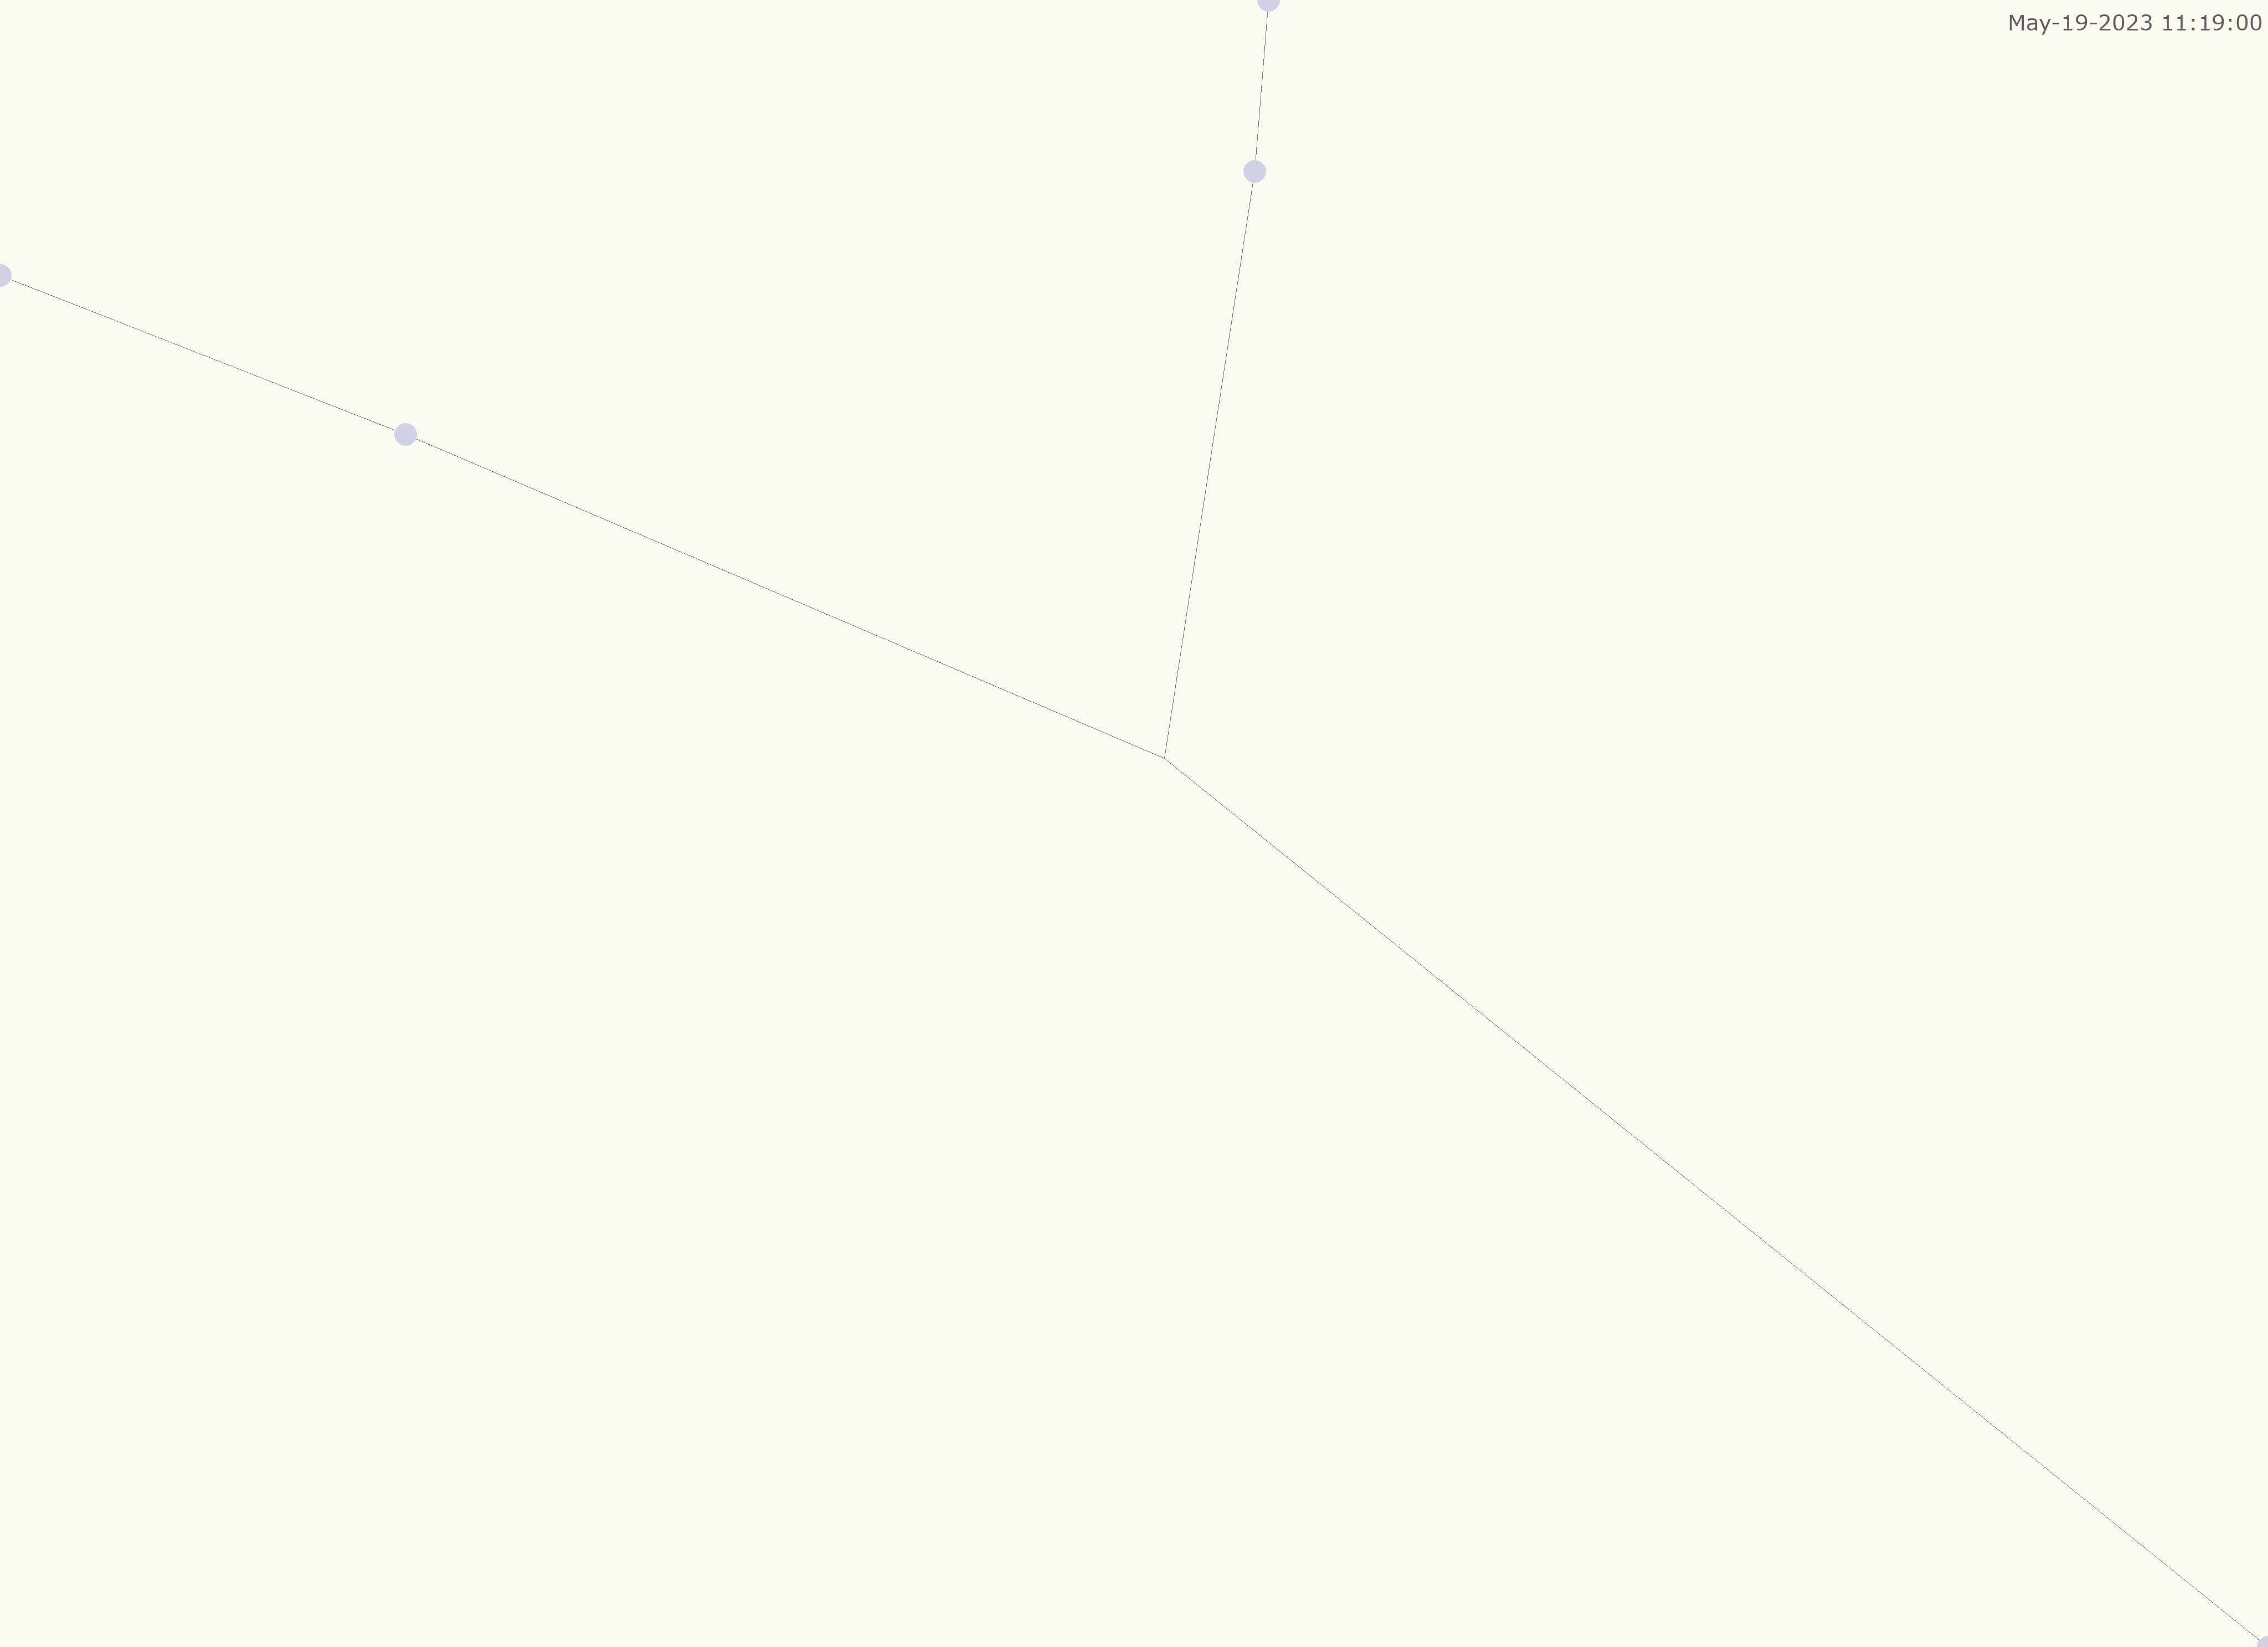

In [7]:
# visualize the model nodes
nodes = model.nodes.dataframe
nodes['draw_size'] = 20

swmmio.draw_model(nodes=nodes, conduits=model.links())

In [16]:
html = swmmio.create_map(model)
from IPython.display import display, HTML, IFrame

IFrame(src='test.html', width='100%', height=600)

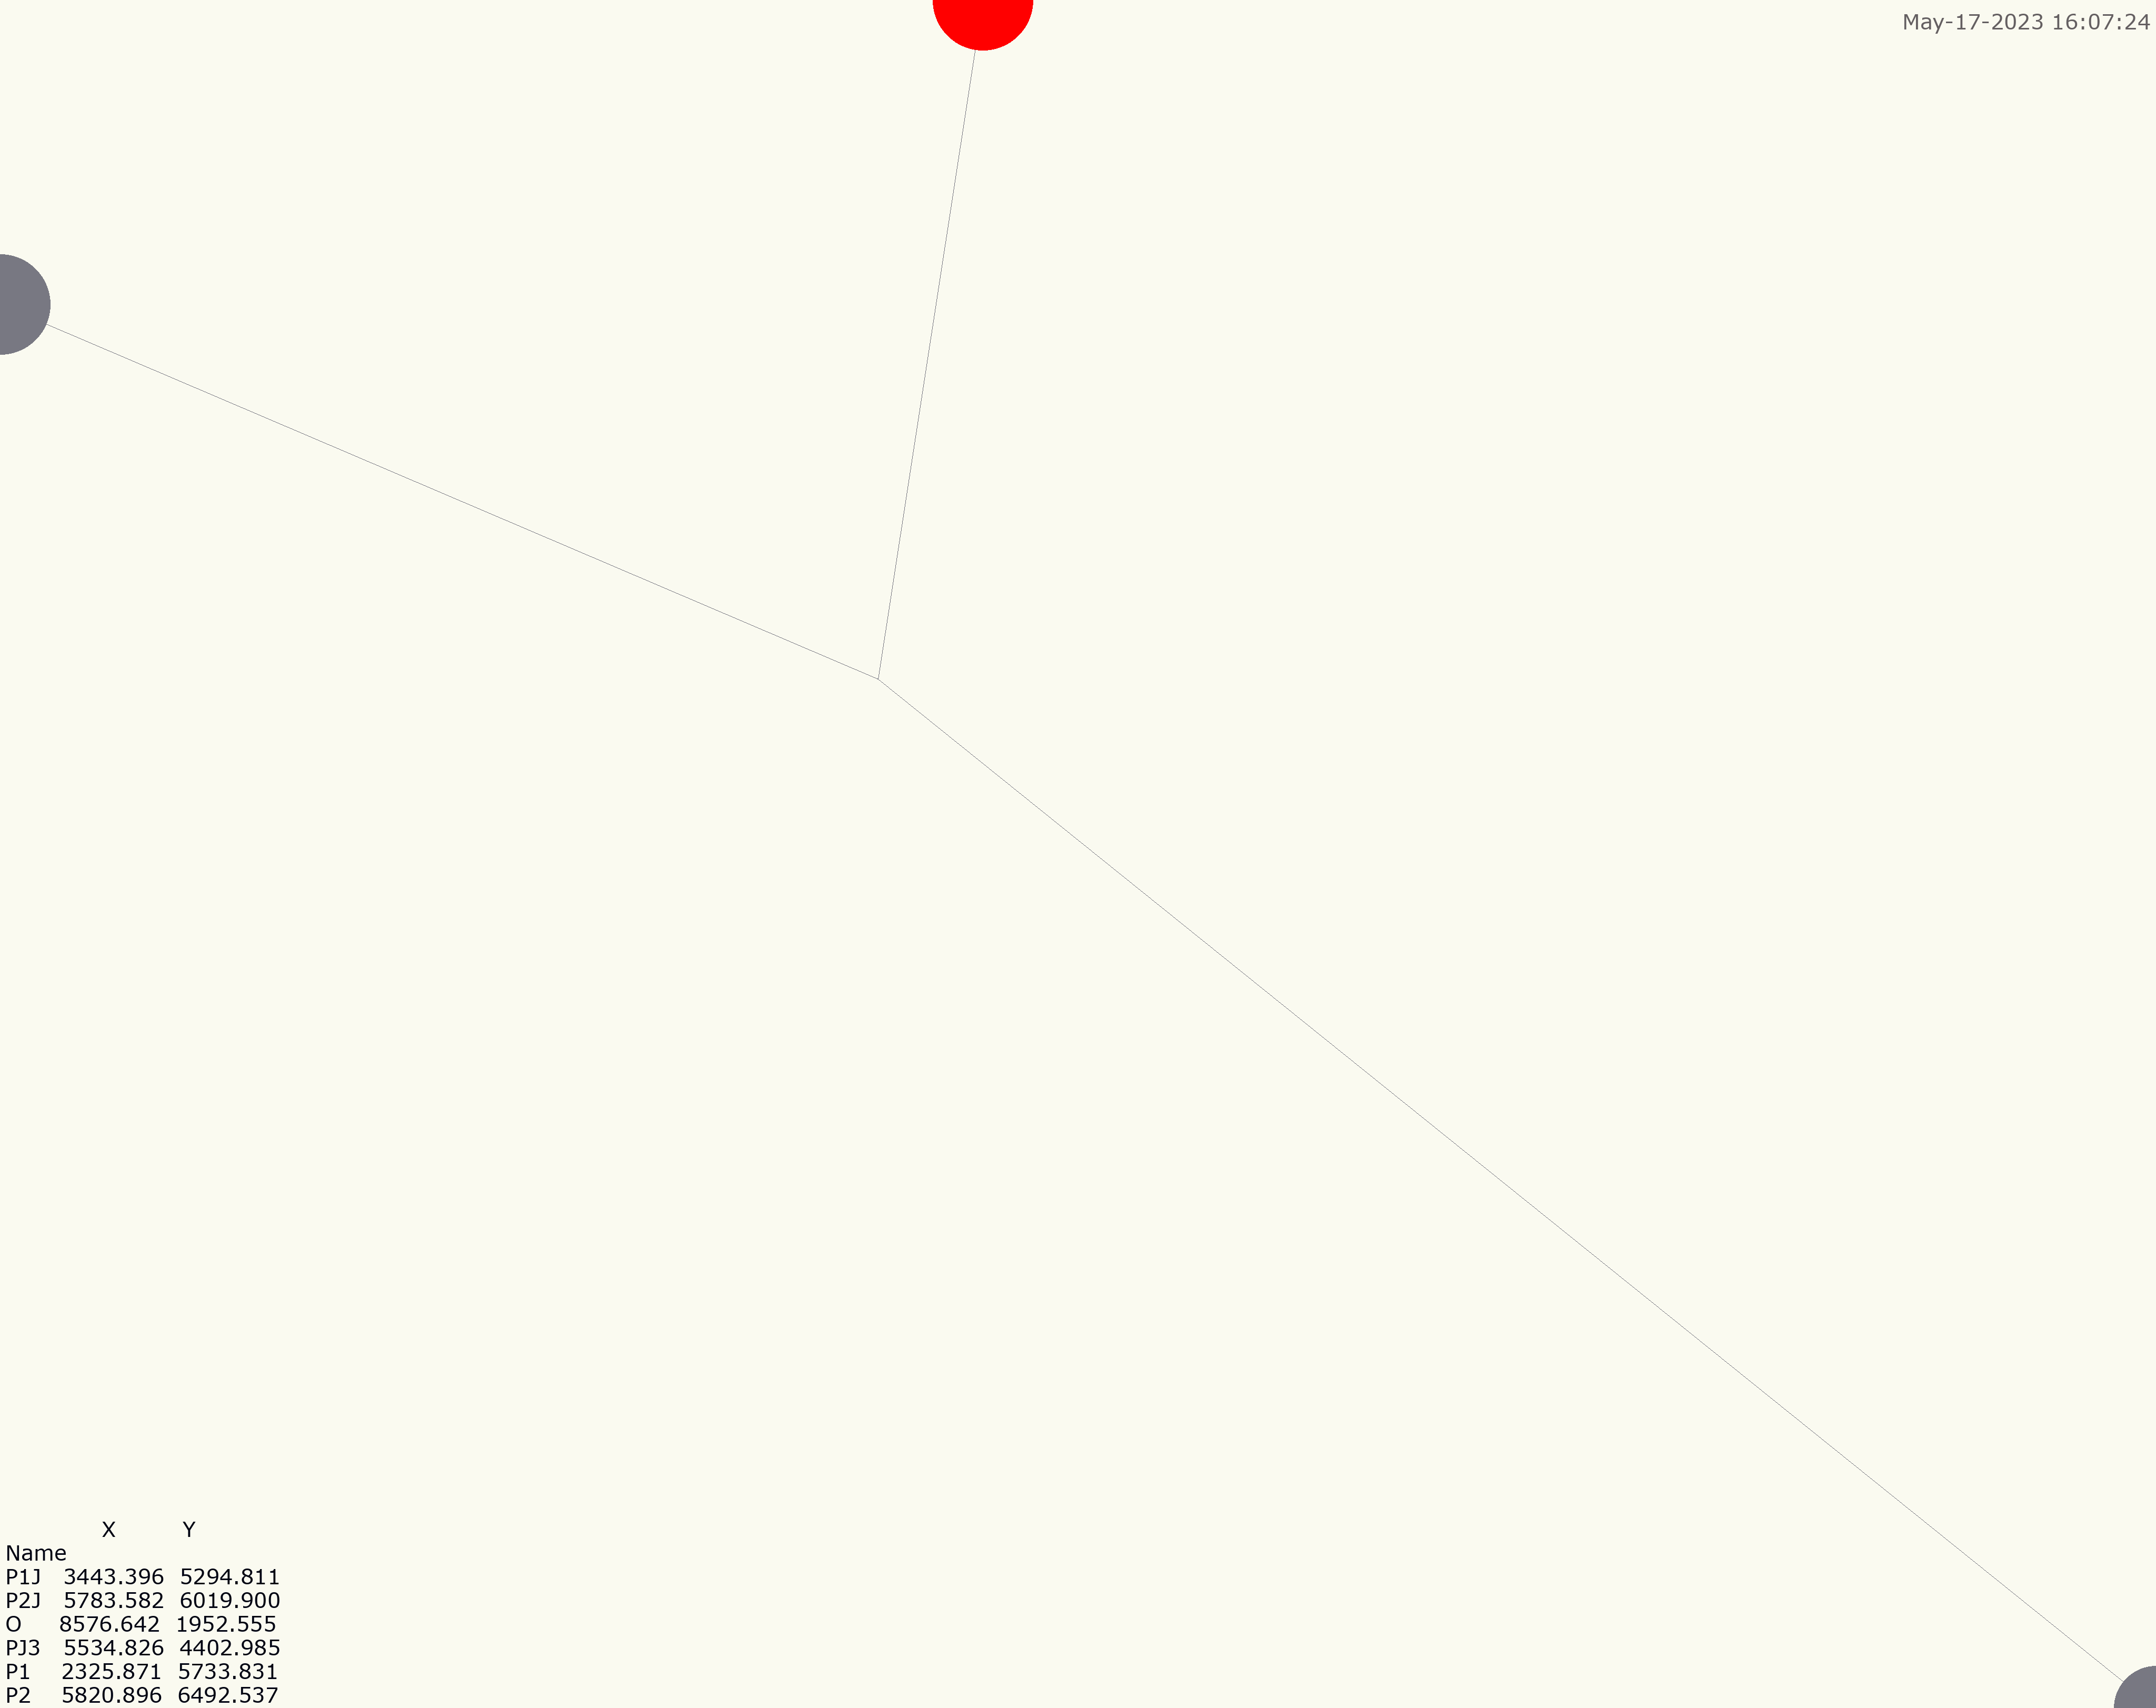

In [232]:
from swmmio.graphics import swmm_graphics as sg 
import pandas as pd
import networkx as nx 

model = swmmio.Model(input_file, crs='EPSG:2817')
nodes = model.nodes.dataframe
nodes['draw_color'] = '#787882'
nodes.loc[['P2J'], 'draw_color'] = '#ff0000'
nodes['draw_size'] = nodes['InvertElev'] 
# model.inp.vertices = pd.DataFrame(index=[7], data=[[320, 520]], columns=['X', 'Y'])
sg.draw_model(conduits=model.conduits(), nodes=nodes, annotation=model.inp.coordinates.to_string())

In [63]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['figure.dpi'] = 200

In [64]:
### Record data during the simulation

In [65]:
simulation = pyswmm.Simulation(inputfile=input_file)

p1 = pyswmm.Nodes(simulation)['P1']
depth = []
timesteps = []
for step in simulation:
    depth.append(p1.depth)
    timesteps.append(simulation.current_time)
simulation.close()

In [66]:
depth = pd.DataFrame(data={"P1 Depth":depth}, index=timesteps)

Text(0.5, 0, 'Timestep')

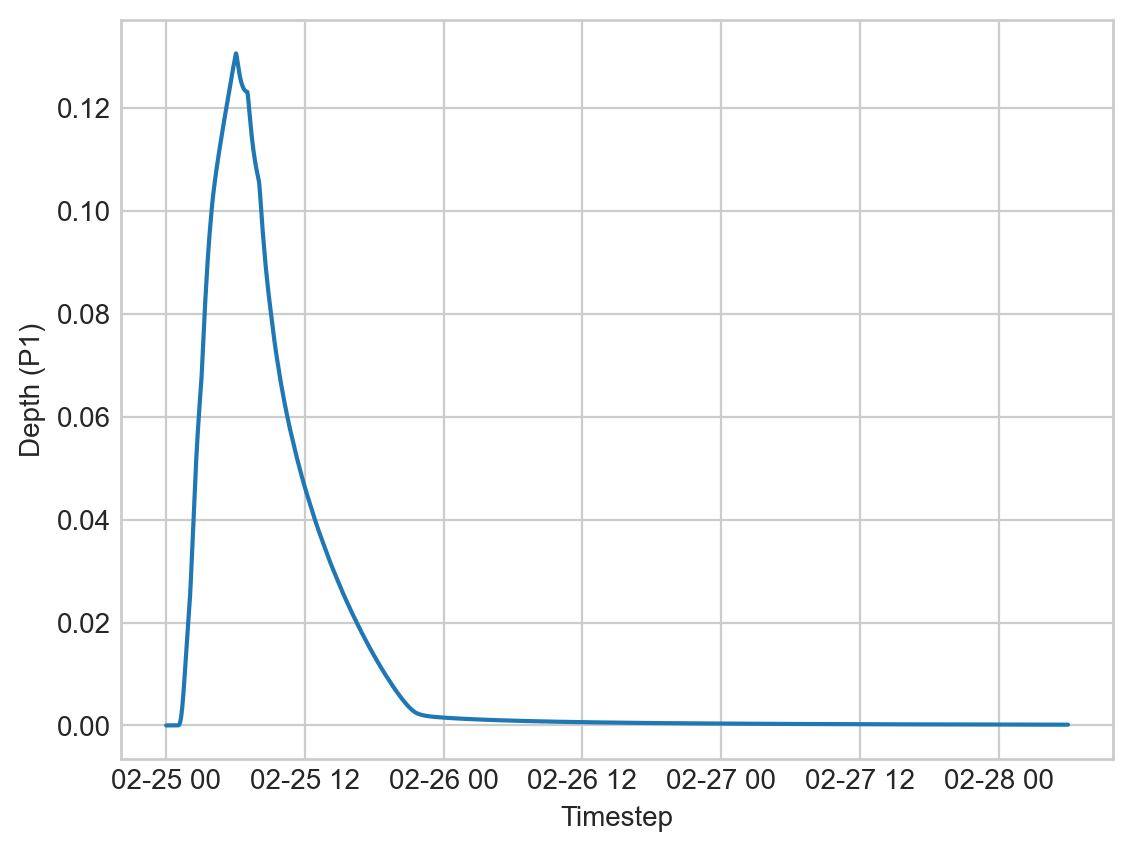

In [67]:
plt.plot(depth)
plt.ylabel("Depth (P1)")
plt.xlabel("Timestep")

In [68]:
### Read data from output file

In [75]:
from pyswmm import Output
from swmm.toolkit.shared_enum import NodeAttribute

In [73]:
output_file = input_file[:-3] + "out"

In [74]:
out = Output(output_file)

In [89]:
depth = out.node_series("P1", attribute=NodeAttribute.INVERT_DEPTH)
depth = pd.DataFrame(data={"P1 Depth": depth.values()}, index=depth.keys())

Text(0.5, 0, 'Timestep')

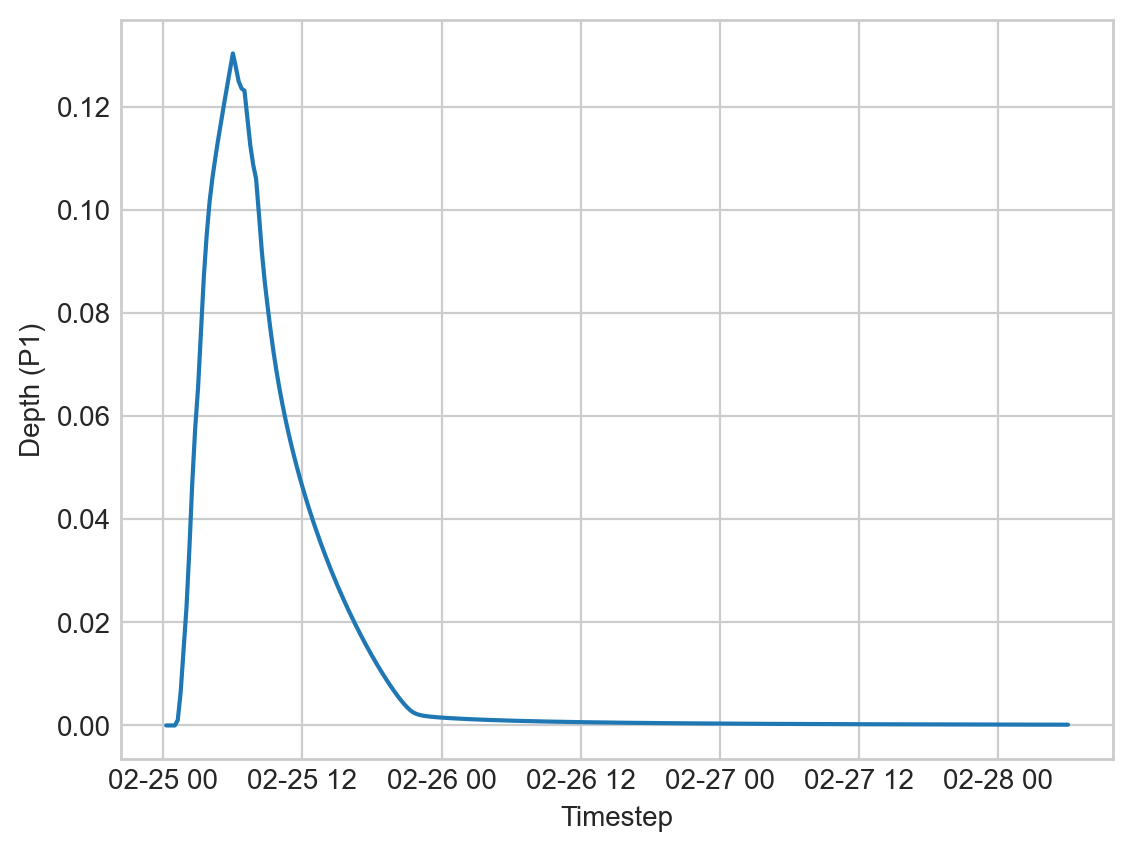

In [91]:
plt.plot(depth)
plt.ylabel("Depth (P1)")
plt.xlabel("Timestep")

## pyswmm power: real-time control

In [99]:
simulation = pyswmm.Simulation(inputfile=input_file)

p1 = pyswmm.Nodes(simulation)['P1']
control_site = pyswmm.Links(simulation)['1']
depth = []
timesteps = []
for step in simulation:
    depth.append(p1.depth)
    timesteps.append(simulation.current_time)
    control_site.target_setting = 0.0
simulation.close()

In [101]:
depth = pd.DataFrame(data={"P1 Depth":depth}, index=timesteps)

Text(0.5, 0, 'Timestep')

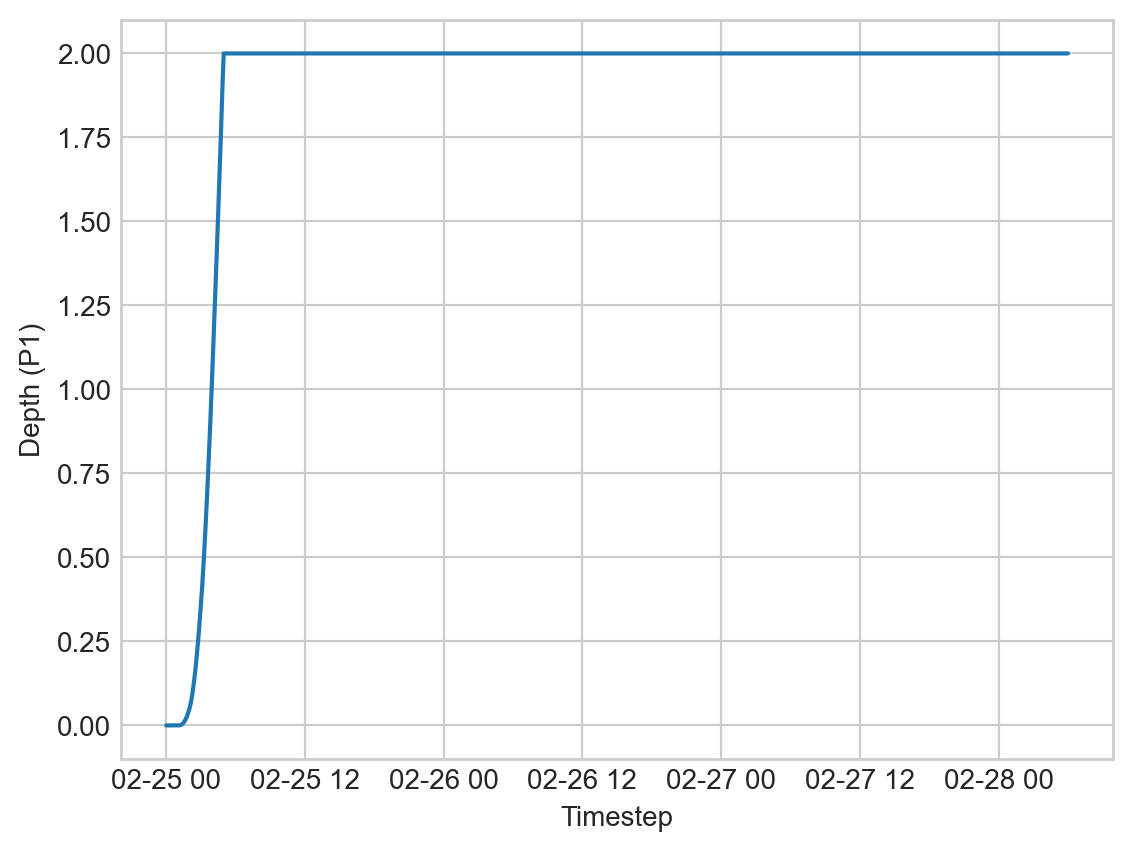

In [102]:
plt.plot(depth)
plt.ylabel("Depth (P1)")
plt.xlabel("Timestep")

In [103]:
# Bonus question: Control the other site!